# 2. The Hasselmann model


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab, need to install multitaper')
  %pip install multitaper

from multitaper import mtspec
from multitaper import mtcross

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)


## The Physical Basis: 1-Box model

Consider the evolution of the energy budget of a linear system described
by temperature $T(t)$ , and forced by an external heat-flux $F(t).$
Assuming the system has thermal inertia $C$, we can write the general
evolution of the model as: 

$$
C\frac{dT}{dt}=Q\left(T\right)+F(t)
$$

where $Q(T)$ are heat fluxes that are caused as a response to temperature
fluctuations. 

Now consider a steady-state $T_{0}$ with steady-state forcing $F_{0}$,
such that $dT/dt=0$ and $Q(T_{0})=F_{0}$. Now consider small deviations
in forcing $\Delta F(t)=F(t)-F_{0}$ that lead to small deviations
from steady state in temperature $\Delta T(t)=T(t)-T_{0}$ such that
$\Delta T/T_{0}\ll1$. We can linearize the system thus:

$$
C\frac{dT}{dt}=Q\left(T_{0}\right)+\left.\frac{dQ}{dT}\right|_{T_{0}}\Delta T+\mathcal{O}\left(\left(\frac{\Delta T}{T_{0}}\right)^{2}\right)+F_{0}+\Delta F(t)
$$

$$
C\frac{d\Delta T}{dt}=-\lambda\Delta T+\Delta F\left(t\right)
$$

where $\lambda$ is usually called the feedback. It can also be thought
of as a restoring rate, or a damping rate. A larger value for $\lambda$
means that an anomaly $\Delta T$ will engender a larger negative
heat flux -$\lambda\Delta T$ that will tend to quickly damp the $\Delta T$
anomaly. I've written $\lambda=-dQ/dt$ because almost all the physical
systems encountered in earth-sciences will have negative feedback.
Having a positive feedback ($dQ/dt>0)$ Implies the system is unstable
and will blow up when taken out of its equilibrium point $T_{0}.$
Thus, in our convention, $\lambda$ will usually have positive values
for a stable system. That being said, signs conventions vary wildly,
and often times you will encounter $\lambda=dQ/dt$ with $\lambda$
taking negative values for a stable system. 

The system will be characterized by two important parameters: (1)
The first is the the equilibrium Sensitivity. At equilibrium:

$$
\frac{dT}{dt}=0\Rightarrow\frac{\Delta T}{\Delta F}=\frac{1}{\lambda},
$$

and (2) the characteristic time scale $\tau_{0}$:

$$
\boxed{\tau_{0}=\frac{C}{\lambda}}
$$

For the rest of the notes, we will drop the $\Delta$ and assume that
$T,F$ and other variables represent small deviations from a steady
state $T_{0},F_{0}.$ The equation for the system can be written as

$$
\boxed{C\frac{dT(t)}{dt}=-\lambda T(t)+F\left(t\right)}
$$
or, equivalently as:

$$
\boxed{\tau_{0}\frac{dT(t)}{dt}=-T(t)+\frac{1}{\lambda}F\left(t\right)}
$$

This is just a simple 1-dimensional linear differential equation.
The interesting part about it is that the forcing term $F(t)$ is
random. In the classic Hasselmann paradigm, $F(t)$ is assumed to
be uncorrelated white noise. 

This type of box models are ubiquitous in Earth Sciences. The original
Hasselmann model was used to represent variations in surface ocean
temperatures, under the influece of heat exchanges with the atmosphere.
The $F(t)$ term represented weather anomalies which, on time-scales
longer than the usual time-scale of weather phenomena (<2 weeks) could
be considered to be random noise. In classical physics, this equation
is called a Langevin equation or, in a slightly different form, an
Orsten-Uhlenbeck process. 




## Discretizing the Hasselmann model for simulations

In this notebook we simulate some examples of the Hasselmann model and visualizing the spectrum. In order to simulate the above differential equation numerically,
we have to discretize it. Taking a simple Forward-Euler finite difference
scheme we can write:

$$
C\frac{T_{n}-T_{n-1}}{\Delta t}=-\lambda T_{n-1}+F_{n}
$$

$$
T_{n}=\left(1-\frac{\Delta t\lambda}{C}\right)T_{n-1}+\frac{\Delta t}{C}F_{n}
$$
The discrete version of the Hasselmann model thus becomes: 

$$
T_{n}=\phi T_{n-1}+\varepsilon_{n}
$$
with: 

$$
\tau_{0}=\frac{C}{\lambda};\;\;\;\phi=1-\frac{\Delta t}{\tau_{0}};\;\;\;\varepsilon_{n}=\frac{\Delta t}{\tau_{o}}\frac{1}{\lambda}F_{n};
$$

## The power spectrum
Let's simulate the Hasselmann model and visualize its spectrum. 

**Spectral estimators**: to estimate the power spectra of a sample of $F_n$ we will use the [multitaper](https://multitaper.readthedocs.io/en/latest/) python package. Since our data are real, the spectra will be symmetric around 0, so we will generally only plot the positive frequencies. 

To simulate the Hasselmann model we will need to choose some values of $\tau_{0},\lambda$ and decide on the variance $\sigma_{F}^{2}$ of the white noise process $F_{n}$. We will also need to choose a time-step $\Delta t$ to discretize the differential equation. 

### White Noise
First, let's visualize a white noise process, $F_n$, which we'll need to force the rest of the model. 



In [10]:
# Set parameters
dt=1/12;     #time-scale. Let's say time is in years, and the time-step is 1 month, so 1/12 years.
T=100        # total integration time [years]
sigma_F=2    # variance of the forcing

# time-vector
t=np.arange(0,T,dt)
N=len(t)

#sample a gaussian white noise process (each F_n is independent and identically distributed, or i.i.d.).
F=stats.norm.rvs(loc=0,scale=sigma_F,size=N)


# Compute the spectral estimates
out=mtspec.MTSpec(F,nw=3,dt=dt,kspec=3)
f=out.freq       # freuencies
S_FF=out.spec    # power spectra
S_FF=S_FF[f>0]         # keep positive frequencies
f=f[f>0]

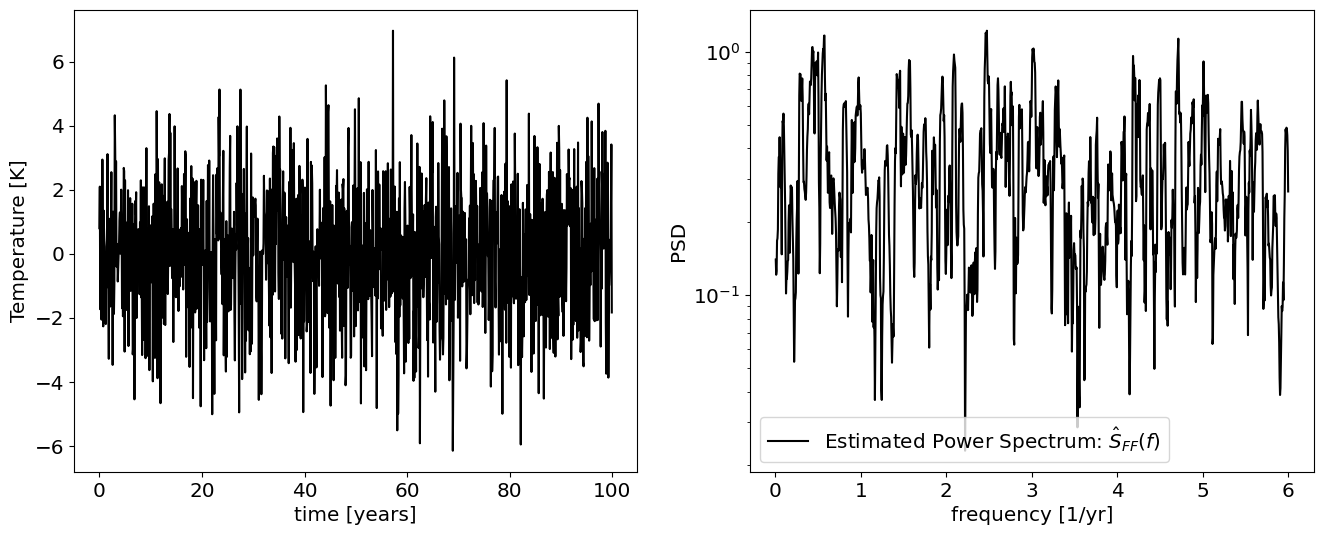

In [11]:
#Plots
plt.figure(figsize=[16,6]);
plt.subplot(1,2,1)
plt.plot(t,F,'k')
plt.xlabel('time [years]')
plt.ylabel('Temperature [K]')

plt.subplot(1,2,2)
plt.plot(f,S_FF,'k',label=r'Estimated Power Spectrum: $\hat S_{FF}(f)$')

plt.xscale('linear')
plt.yscale('log')
plt.xlabel('frequency [1/yr]')
plt.ylabel('PSD')
plt.legend()


### The power spectrum of a Hasselmann model

Now let's simulate a Hasselmann Model. 

You should play around and change the correlation time scale, $\tau_0$, the forcing variance, and the feedback and see how the spetrum changes (you may need to keep note of the axis limits). 

In [5]:
dt=1/12;     #time-scale. Let's say time is in years, and the time-step is 1 month, so 1/12 years.
T=500        # total integration time [years]
sigma_F=2    # variance of the forcing
tau_0= 3       # time-scale tau=C/lambda [years]
lam= 7       # feedback lambda

# time-vector
t=np.arange(0,T,dt)
N=len(t)

#sample a gaussian white noise process (each F_n is independent and identically distributed, or i.i.d.).
F=stats.norm.rvs(loc=0,scale=sigma_F,size=N)

# calculate phi and eps for the discretization
phi=   1-dt/tau_0
eps = (dt/tau_0/lam)*F;

## Simulate the Hasselmann model
#pre-allocate
T=np.zeros(N)

for n in range(1,N):
            T[n]=phi*T[n-1]+eps[n]

out=mtspec.MTSpec(T,nw=3,dt=dt,kspec=3)
f=out.freq
S_TT=out.spec
S_TT=S_TT[f>0]
f=f[f>0]

Let's now plot the temperature time-series as well as the power spectrum and the autocorrelation function. We will use a log-log plot for the power spectrum. 

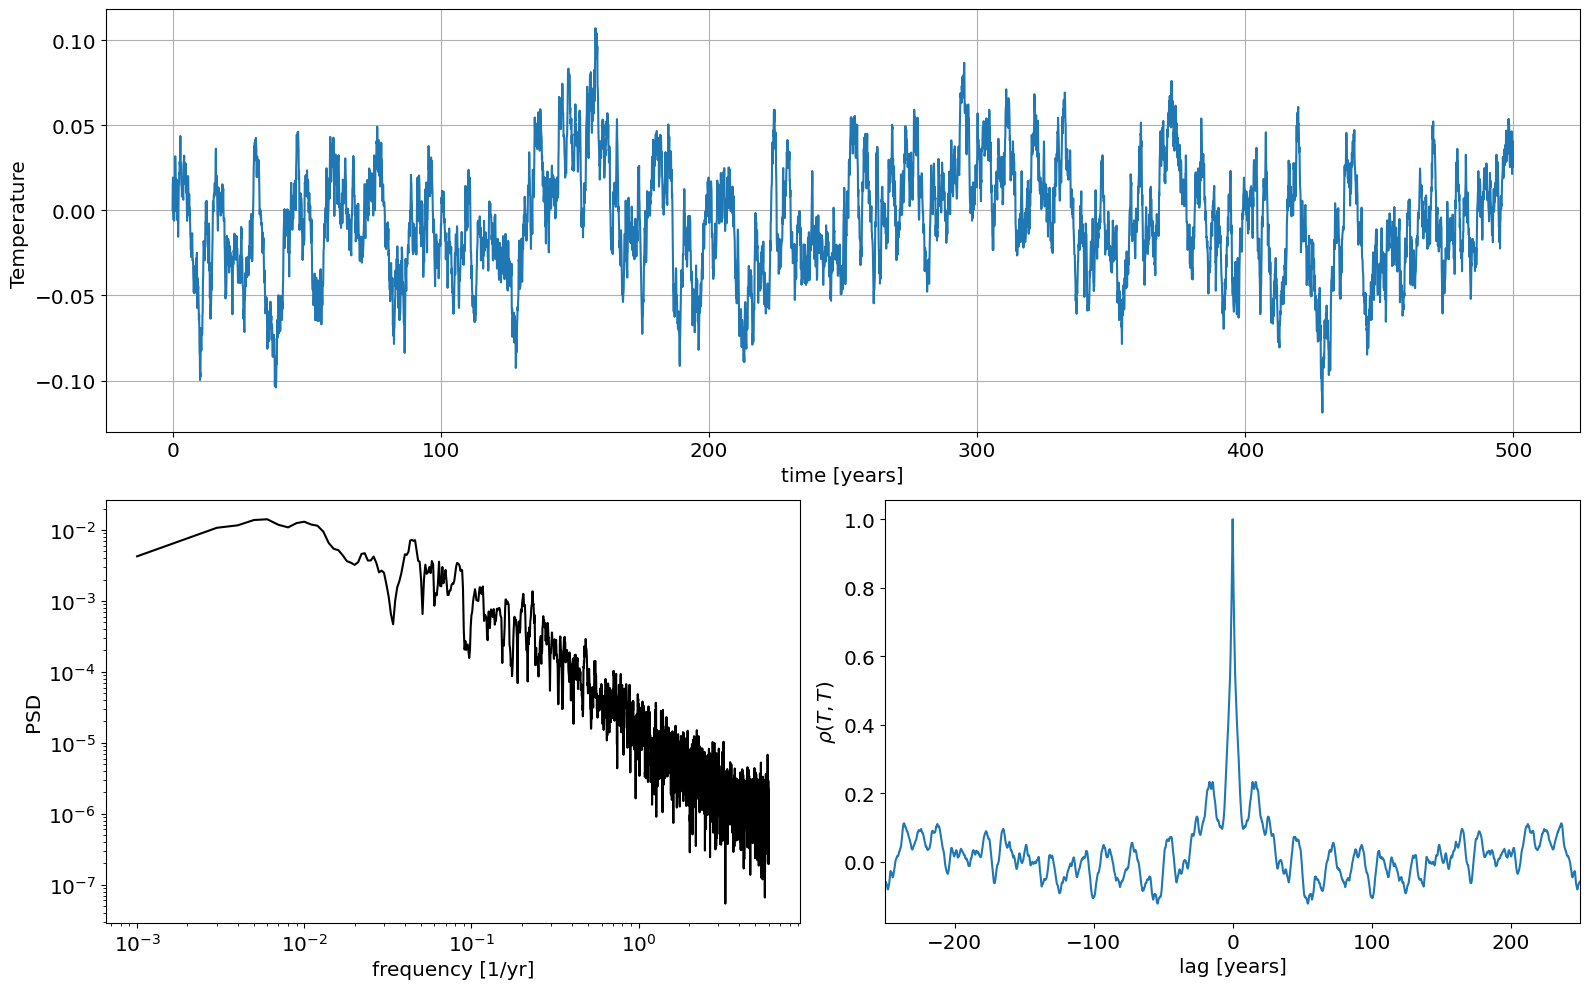

In [6]:
# Plots

plt.figure(figsize=[16,10]);

plt.subplot(2,1,1)
    
plt.plot(t,T,'-')
plt.grid()
plt.xlabel('time [years]')
plt.ylabel('Temperature ')

plt.subplot(2,2,3)
plt.plot(f,S_TT,'k',label=r'Estimated Power Spectrum: $\hat S_{FF}(f)$')

plt.xlabel('frequency [1/yr]')
plt.ylabel('PSD')

plt.xscale('log')
plt.yscale('log')

# Plot autocorrelation function
plt.subplot(2,2,4)

acf=np.correlate(T,T,mode='full')
acf=acf/np.max(acf)
lags=np.arange(-N+1,N)

plt.plot(lags*dt,acf)
plt.xlabel('lag [years]')
plt.ylabel(r'$\rho(T,T)$')

plt.xlim(-N*dt/2,N*dt/2)


plt.tight_layout()

### Spectrum as a function of parameters

The cell below plots time series, power spectra and auto-correlation functions for different values of the parameters. 

Note that in the code below we prescribe the variance of the temperature time-series, rather than of the forcing. 

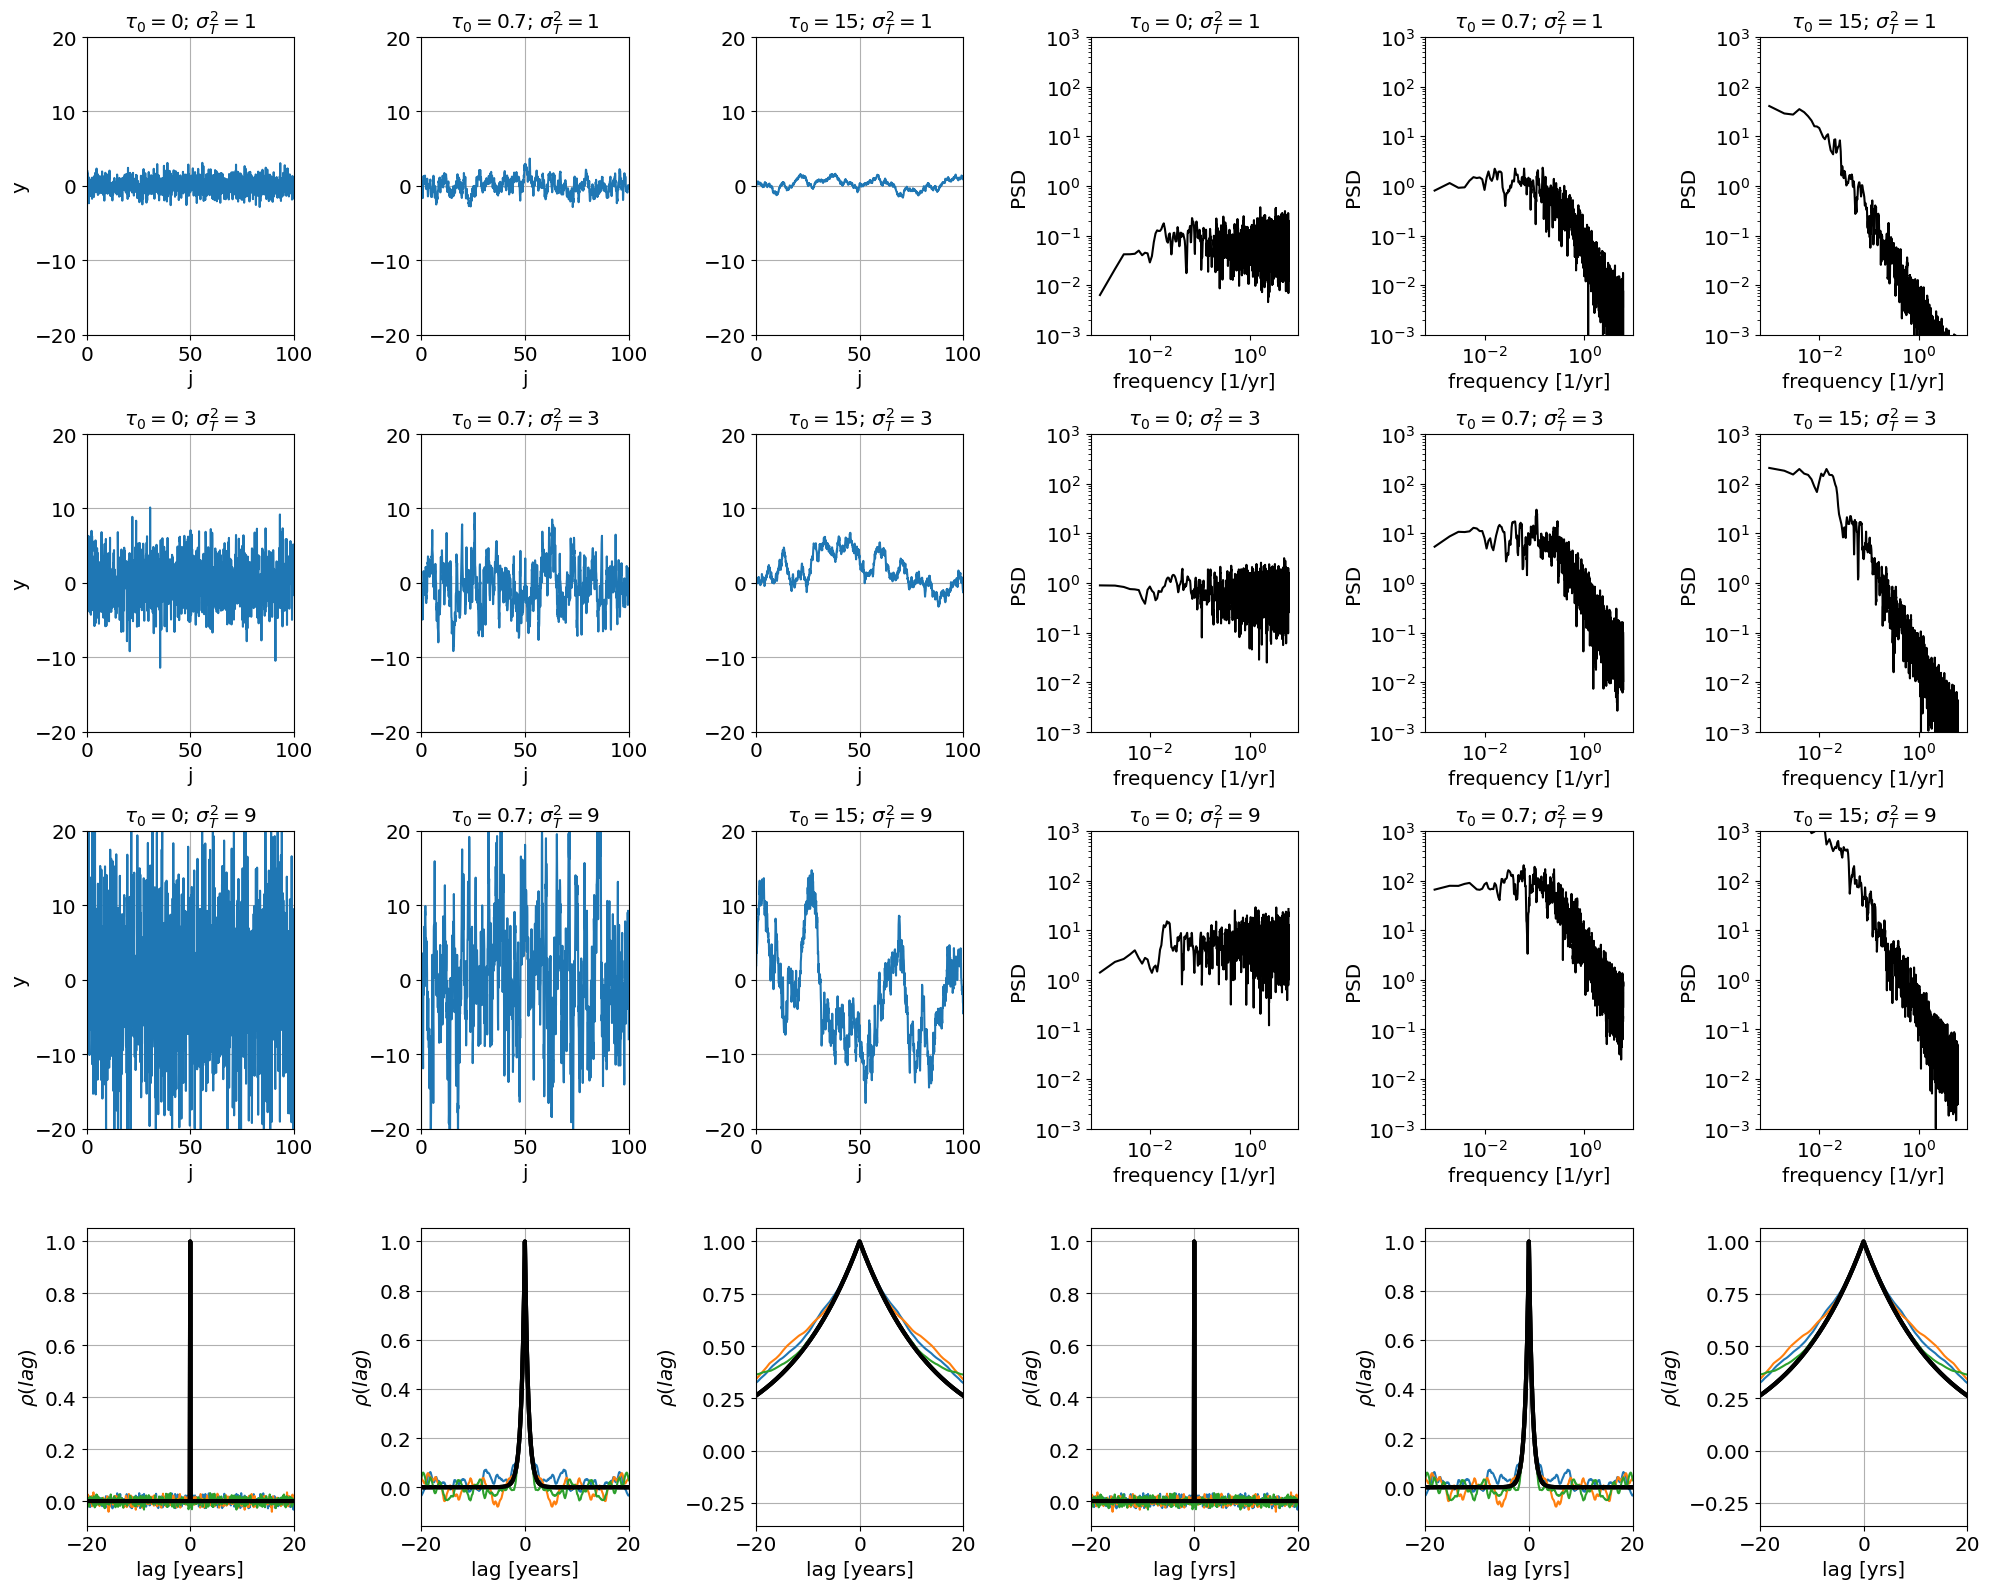

In [12]:
#Discrete time series
dt=1/12;
T=500

sigma_vec=[1,3,9];
tau_vec=[0,0.7,15];

# Time Domain
t=np.arange(0,T,dt)
N=len(t)


plt.subplots(4,6,figsize=[20,16])
for ind_sigma in range(3):
    for ind_tau in range(3):
        # autocorrelation coefficient & total variance of the AR(1) process
        tau_0=tau_vec[ind_tau]
        sigma_T=sigma_vec[ind_sigma];
        
        if ind_tau==0:
            phi=0;
        else:
            phi=1-dt/tau_0
        
        #pre-allocate T
        T=np.zeros(N)

        ## Simulate AR1 process: note that the variance of the noise doesn't matter nowo, since we will rescale X)
        eps=stats.norm.rvs(loc=0,scale=1,size=N);
        for j in range(1,N):
            T[j]=phi*T[j-1]+stats.norm.rvs(loc=0,scale=1);
        
        #rescale X to have a given variance
        T=T*sigma_T/np.std(T)



        out=mtspec.MTSpec(T,nw=3,dt=dt,kspec=3)
        f=out.freq
        S_TT=out.spec
        S_TT=S_TT[f>0]
        f=f[f>0]

        acf=np.correlate(T,T,mode='full')
        acf=acf/np.max(acf)
        lags=np.arange(-N+1,N)
        
        ## Make Plots
    
        subplot_ind=6*(ind_sigma)+(ind_tau+1)
        plt.subplot(4,6,subplot_ind)
    
        plt.plot(t,T,'-')
        #plt.hlines(0,0,N,'r')
        plt.grid()
        plt.ylim(-20,20)
        plt.title(r'$\tau_0=$'+str(round(tau_0,2))+r'; $\sigma^2_T=$'+str(round(sigma_vec[ind_sigma])))
        plt.xlabel('j')
        plt.xlim(0,100)
        if ind_tau==0:
            plt.ylabel('y')

        subplot_ind=6*(ind_sigma)+3+(ind_tau+1)
        plt.subplot(4,6,subplot_ind)
        plt.plot(f,S_TT,'k',label=r'Estimated Power Spectrum: $\hat S_{FF}(f)$')
        #plt.hlines(sigma_eps**2*dt,np.min(f),np.max(f),'r',label=r'Theoretical Power Spectrum: $S_{FF}=$constant')
        plt.title(r'$\tau_0=$'+str(round(tau_0,2))+r'; $\sigma^2_T=$'+str(round(sigma_vec[ind_sigma])))
        
        plt.xscale('log')
        plt.yscale('log')
        plt.xlabel('frequency [1/yr]')
        plt.ylabel('PSD')
        plt.ylim(1E-3,1E3)
                

    
        plt.subplot(4,6,18+ind_tau+1)
        plt.plot(lags/12,acf,'-')
        plt.plot(lags/12,phi**(np.abs(lags)),'k',linewidth=3)
        plt.grid()
        plt.ylabel(r'$\rho(lag)$')
        plt.xlabel('lag [years]')
        plt.xlim(-20,20)


        plt.subplot(4,6,18+3+ind_tau+1)
        plt.plot(lags/12,acf,'-')
        plt.plot(lags/12,phi**(np.abs(lags)),'k',linewidth=3)
        plt.grid()
        plt.ylabel(r'$\rho(lag)$')
        plt.xlabel('lag [yrs]')
        plt.xlim(-20,20)
plt.tight_layout()

Note that the higher the time-scale $\tau_0$, the more correlate the data. Indeed, $\tau_0$ is the decorrelation time-scale. For the Hasselmann model, the expected correlation (black line) is $\rho(T(t),T(t+\tau))=\exp^{-\tau/\tau_0}$. At the same time, $1/\tau_0$ is also the frequency at which the power spectra goes from having a slope to being flat (i.e. "white").  

In general, the higher the average spectrum the more variance the time series. By the Parseval theorem, the variance is the integral of the PSD. So for processes where the power spectra have more spectral density at lower frequencies (i.e. the case of large $\tau_0$) more of the variance comes from these lower frequencies. 